Using TensorFlow backend.


Train on 1991 samples, validate on 854 samples
Epoch 1/30
1991/1991 [==============================] - 88s 44ms/step - loss: 9.6674 - accuracy: 0.2898 - val_loss: 1.2679 - val_accuracy: 0.6581
Epoch 2/30
1991/1991 [==============================] - 84s 42ms/step - loss: 0.7529 - accuracy: 0.8036 - val_loss: 0.3833 - val_accuracy: 0.9016
Epoch 3/30
1991/1991 [==============================] - 82s 41ms/step - loss: 0.1870 - accuracy: 0.9382 - val_loss: 0.1445 - val_accuracy: 0.9403
Epoch 4/30
1991/1991 [==============================] - 82s 41ms/step - loss: 0.0829 - accuracy: 0.9759 - val_loss: 0.0863 - val_accuracy: 0.9778
Epoch 5/30
1991/1991 [==============================] - 81s 41ms/step - loss: 0.0411 - accuracy: 0.9940 - val_loss: 0.0581 - val_accuracy: 0.9871
Epoch 6/30
1991/1991 [==============================] - 82s 41ms/step - loss: 0.0250 - accuracy: 0.9960 - val_loss: 0.0546 - val_accuracy: 0.9906
Epoch 7/30
1991/1991 [==============================] - 82s 41ms/step - loss:

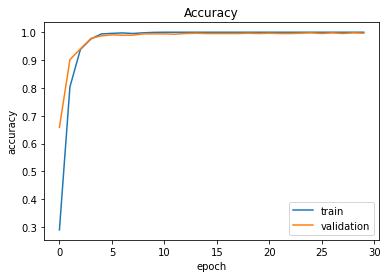

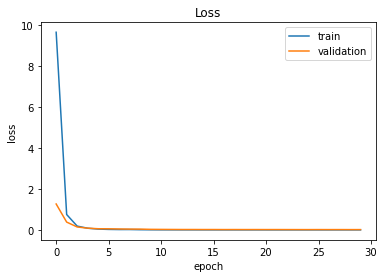

1.0


In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
 
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


train = pd.read_csv('train/train1.csv')
test = pd.read_csv('train/test1.csv')

labels = train['label'].values

unique_val = np.array(labels)
np.unique(unique_val)

train.drop('label', axis = 1, inplace = True)

images = train.values
images = np.array([np.reshape(i, (60, 60)) for i in images])
images = np.array([i.flatten() for i in images])

from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(labels)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state = 101)


batch_size = 128
num_classes = 24
epochs = 30

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(x_train.shape[0], 60, 60, 1)
x_test = x_test.reshape(x_test.shape[0], 60, 60, 1)

def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
 
    return X
ops.reset_default_graph()

def convolutional_block(X, f, filters, stage, block, s=2):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name=bn_name_base + '1')(X_shortcut)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
 
    return X

ops.reset_default_graph()

def ResNet50(input_shape = (60, 60, 1), classes = 24):
 
    X_input = Input(input_shape)
 
    X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (7, 7), strides = (2,2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2,2))(X)
 

    X = convolutional_block(X, f = 3, filters = [512,512,2048], stage = 5, block = 'a', s = 2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')

    X = AveragePooling2D((2, 2), name='avg_pool')(X)
 
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', name = 'fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
 
    model = Model(inputs = X_input, outputs = X, name = 'ResNet50')
 
    return model


model = ResNet50(input_shape = (60, 60, 1), classes = 24)

model.compile("adam", "categorical_crossentropy", ["accuracy"])

history=model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=epochs, batch_size=batch_size)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()

test_labels = test['label']
test.drop('label', axis = 1, inplace = True)
test_images = test.values
test_images = np.array([np.reshape(i, (60, 60)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])
test_labels = label_binrizer.fit_transform(test_labels)
test_images = test_images.reshape(test_images.shape[0], 60, 60, 1)
y_pred = model.predict(test_images)
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, y_pred.round()))
